In [10]:
pip install efficientnet

     |████████████████████████████████| 50 kB 2.7 MB/s eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [37]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os,cv2
import numpy as np
import random
from IPython.display import Image
from keras.preprocessing import image
from keras import optimizers
from keras.models import Model , Sequential
from keras.applications.imagenet_utils import preprocess_input
import matplotlib.pyplot as plt
import seaborn as sns
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau , LearningRateScheduler
from keras.applications.vgg16 import VGG16 , preprocess_input
from keras.layers import  Conv2D,MaxPooling2D,Dropout,Activation, Flatten, Dense,GlobalAveragePooling2D,BatchNormalization
from keras.optimizers import Adam , RMSprop
import warnings
warnings.filterwarnings('ignore')

In [2]:
def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(42)
   np.random.seed(42)
   random.seed(42)
reset_random_seeds()

In [3]:
!pwd

/kaggle/working


In [4]:
cd /kaggle/input/

/kaggle/input


In [5]:
train_dir="../input/eight-dance-forms/train"
test_dir="../input/eight-dance-forms/test"
train=pd.read_csv('../input/eight-dance-forms/train.csv')
test = pd.read_csv('../input/eight-dance-forms/test.csv')
print('no of training images ',train.shape[0])
print('no of test images ',test.shape[0])
train.head()

no of training images  364
no of test images  156


,Image,target
0,96.jpg,manipuri
1,163.jpg,bharatanatyam
2,450.jpg,odissi
3,219.jpg,kathakali
4,455.jpg,odissi


In [6]:
pwd

'/kaggle/input'

In [7]:
train_fnames = os.listdir(train_dir)
test_fnames = os.listdir(test_dir)

print(train_fnames[:9])
print(test_fnames[:9])

['234.jpg', '287.jpg', '87.jpg', '404.jpg', '167.jpg', '257.jpg', '163.jpg', '148.jpg', '251.jpg']
['170.jpg', '438.jpg', '458.jpg', '510.jpg', '138.jpg', '238.jpg', '38.jpg', '479.jpg', '264.jpg']


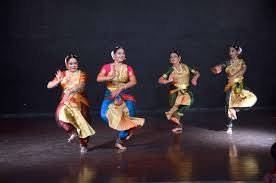

In [8]:
Image(os.path.join(train_dir,train.iloc[1,0]),width=250,height=250)

In [11]:
import efficientnet.tfkeras as enet

In [12]:
datagen=ImageDataGenerator(rescale=1./255,validation_split=0.25)

train_generator=datagen.flow_from_dataframe(dataframe=train,directory=train_dir,x_col='Image',
                                            y_col='target',class_mode='categorical',batch_size=8,
                                            target_size=(224,224),color_mode='rgb',seed=42)


validation_generator=datagen.flow_from_dataframe(dataframe=train,directory=train_dir,x_col='Image',
                                                y_col='target',class_mode='categorical',batch_size=8,
                                                target_size=(224,224),color_mode='rgb',seed=42)

test_datagen=ImageDataGenerator(rescale=1./255)
test_generator=test_datagen.flow_from_dataframe(dataframe=test,directory=test_dir,x_col="Image",y_col=None,
                                                        batch_size=32,seed=42,shuffle=False,
                                                            class_mode=None,target_size=(224,224),color_mode='rgb')

Found 364 validated image filenames belonging to 8 classes.
Found 364 validated image filenames belonging to 8 classes.
Found 156 validated image filenames.


In [22]:
base_model = enet.EfficientNetB2(include_top=False, pooling='avg', weights='imagenet')
x=base_model.output
x = BatchNormalization()(x)
x = Dense(256)(x)
x = Dropout(0.7)(x)

preds=Dense(8,activation='softmax')(x) #final layer with softmax activation
model=Model(inputs=base_model.input,outputs=preds)



In [23]:
len(model.layers)

337

In [24]:
for layer in model.layers[:100]:
    layer.trainable=False
for layer in model.layers[100:]:
    layer.trainable=True

In [25]:
pwd

'/kaggle/working'

In [26]:
'''def scheduler(epoch, lr):
...   if epoch < 10:
...     return lr
...   else:
...     return lr * tf.math.exp(-0.1)'''

'def scheduler(epoch, lr):\n  if epoch < 10:\n    return lr\n  else:\n    return lr * tf.math.exp(-0.1)'

In [27]:
cd /kaggle/working/

/kaggle/working


In [28]:
early = EarlyStopping(monitor='val_loss',patience=5,verbose=1,restore_best_weights=True)
checkpoint = ModelCheckpoint('model.h5', monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                                   verbose=1, mode='min')
#lrs = LearningRateScheduler(scheduler)

model.compile(optimizer='adam',loss="categorical_crossentropy",metrics=["accuracy"])

In [29]:
history=model.fit_generator(train_generator,epochs=30,
                            validation_data=validation_generator,
                            callbacks=[early,checkpoint, reduce_lr])

Epoch 1/30
46/46 [==============================] - ETA: 0s - loss: 3.8877 - accuracy: 0.3407
Epoch 00001: val_accuracy improved from -inf to 0.65659, saving model to model.h5
46/46 [==============================] - 15s 332ms/step - loss: 3.8877 - accuracy: 0.3407 - val_loss: 1.2433 - val_accuracy: 0.6566 - lr: 0.0010
Epoch 2/30
46/46 [==============================] - ETA: 0s - loss: 2.9278 - accuracy: 0.5687
Epoch 00002: val_accuracy improved from 0.65659 to 0.67857, saving model to model.h5
46/46 [==============================] - 14s 294ms/step - loss: 2.9278 - accuracy: 0.5687 - val_loss: 1.6827 - val_accuracy: 0.6786 - lr: 0.0010
Epoch 3/30
46/46 [==============================] - ETA: 0s - loss: 2.2067 - accuracy: 0.7363
Epoch 00003: val_accuracy improved from 0.67857 to 0.73626, saving model to model.h5
46/46 [==============================] - 13s 288ms/step - loss: 2.2067 - accuracy: 0.7363 - val_loss: 1.3394 - val_accuracy: 0.7363 - lr: 0.0010
Epoch 4/30
46/46 [=============

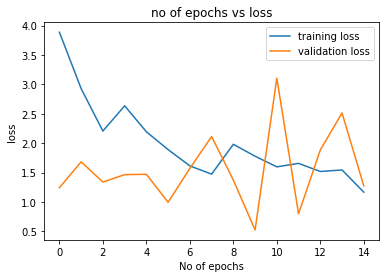

In [30]:
acc=history.history['loss'] 
acc_val=history.history['val_loss']

epochs_ = range(len(acc))
plt.plot(epochs_,acc,label='training loss')
plt.xlabel('No of epochs')
plt.ylabel('loss')

  ## getting validation loss of each epochs
plt.plot(epochs_,acc_val,label="validation loss")
plt.title('no of epochs vs loss')
plt.legend()

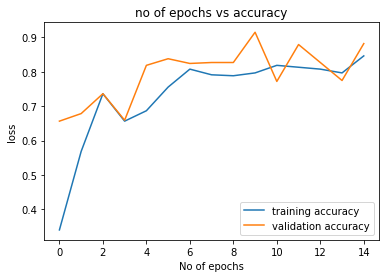

In [31]:
acc=history.history['accuracy'] 
acc_val=history.history['val_accuracy']

epochs_ = range(len(acc))
plt.plot(epochs_,acc,label='training accuracy')
plt.xlabel('No of epochs')
plt.ylabel('loss')

  ## getting validation loss of each epochs
plt.plot(epochs_,acc_val,label="validation accuracy")
plt.title('no of epochs vs accuracy')
plt.legend()

In [32]:
model.load_weights('model.h5')

In [33]:
model.evaluate_generator(generator=validation_generator)

[0.5248080492019653, 0.9148351550102234]

In [34]:
from tensorflow.keras.applications import DenseNet201
img_size = 224
base_model = DenseNet201(include_top = False,
                         weights = 'imagenet',
                         input_shape = (img_size,img_size,3))

for layer in base_model.layers[:675]:
    layer.trainable = False

for layer in base_model.layers[675:]:
    layer.trainable = True

74842112/74836368 [==============================] - 1s 0us/step


In [41]:
image_size = 224
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(8, activation='softmax'))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1920)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 15368     
Total params: 18,337,352
Trainable params: 1,161,352
Non-trainable params: 17,176,000
_________________________________________________________________


In [42]:
filepath= "model_densenet.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=False)

early_stopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

callbacks_list = [
        checkpoint,
        early_stopping]

In [43]:
history=model.fit_generator(train_generator,epochs=50,
                            validation_data=validation_generator,
                            callbacks=callbacks_list)

Epoch 1/50
46/46 [==============================] - ETA: 0s - loss: 1.5388 - accuracy: 0.4505
Epoch 00001: val_accuracy improved from -inf to 0.86538, saving model to model_densenet.h5
46/46 [==============================] - 18s 385ms/step - loss: 1.5388 - accuracy: 0.4505 - val_loss: 0.4075 - val_accuracy: 0.8654
Epoch 2/50
46/46 [==============================] - ETA: 0s - loss: 0.6065 - accuracy: 0.8626
Epoch 00002: val_accuracy improved from 0.86538 to 0.97527, saving model to model_densenet.h5
46/46 [==============================] - 14s 302ms/step - loss: 0.6065 - accuracy: 0.8626 - val_loss: 0.0760 - val_accuracy: 0.9753
Epoch 3/50
45/46 [============================>.] - ETA: 0s - loss: 0.2604 - accuracy: 0.9607
Epoch 00003: val_accuracy improved from 0.97527 to 0.99725, saving model to model_densenet.h5
46/46 [==============================] - 14s 302ms/step - loss: 0.2564 - accuracy: 0.9615 - val_loss: 0.0228 - val_accuracy: 0.9973
Epoch 4/50
46/46 [=========================

In [45]:
model.load_weights('model_densenet.h5')
model.evaluate_generator(generator=validation_generator)

[0.007476627826690674, 1.0]

In [46]:
test_generator.reset()
pred2=model.predict_generator(test_generator,verbose=1)
pred2

5/5 [==============================] - 2s 454ms/step


array([[6.37918711e-02, 7.90307149e-02, 1.17676696e-02, ...,
        1.46383522e-02, 5.88584960e-01, 5.41002899e-02],
       [1.01767361e-01, 9.29477662e-02, 6.39413968e-02, ...,
        4.41075057e-01, 1.06605645e-02, 8.37685838e-02],
       [7.12884292e-02, 2.97622718e-02, 7.27962703e-04, ...,
        4.66224402e-02, 7.54709661e-01, 6.55731708e-02],
       ...,
       [6.19537057e-03, 9.82452750e-01, 9.57521916e-05, ...,
        7.68510276e-04, 3.07909190e-03, 3.00664036e-03],
       [1.54174436e-02, 3.69517170e-02, 3.12719331e-03, ...,
        1.90895051e-03, 9.21174467e-01, 2.21603550e-03],
       [3.39957973e-04, 5.72559470e-03, 3.53310956e-04, ...,
        2.82729103e-04, 6.29637972e-04, 9.91358280e-01]], dtype=float32)

In [47]:
predicted_class_indices=np.argmax(pred2,axis=1)
predicted_class_indices

NameError: name 'pred' is not defined

In [ ]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
predictions

In [ ]:
pwd

In [ ]:
cd /kaggle/working/

In [ ]:
filenames=test_generator.filenames
results=pd.DataFrame({"Image":filenames,
                      "target":predictions})
results.to_csv("mobile_results.csv",index=False)

In [ ]:
result = pd.read_csv('./mobile_results.csv')
result.head()